# Predicting Customer Churn and Optimizing Marketing Strategies through Customer Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn import over_sampling,under_sampling
from sklearn.ensemble import RandomForestClassifier

## Exploratory Data Analysis

In [2]:
df=pd.read_csv('Telco_Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# duplicated data
df.duplicated().any()

False

No missing value and duplicated data

In [5]:
# Split the column by data type
category=['customerID','gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','TotalCharges','Churn']
numeric=['SeniorCitizen','tenure','MonthlyCharges']

In [6]:
# Category Type Data Analysis
df[category].describe()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


The data is logic, but change it to numeric type is necessary for machine learning

In [8]:
df[numeric].describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Senior citizen column is actually a category data. Meanwhile, for the first glance the tenure and monthly charges column might have a good distribution as the mean is almost the same with the median, but further analysis is needed

## Exploratory Data Analysis Summary

- No missing value and duplicated data
- Categorical data is make sense but need to be changed to numeric type
- Numerical data is make sense (senior citizen column is a categorical data)

## Data Preprocessing

### Category data

In [9]:
df[category].sample(4)

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
197,6168-YBYNP,Male,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,6519.75,No
6809,9274-CNFMO,Male,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,308.7,Yes
2920,9453-PATOS,Female,Yes,No,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,6155.4,No
6911,0508-SQWPL,Female,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),1087.7,No


In [15]:
# changing all yes and no value
pd.set_option('future.no_silent_downcasting', True)
df=df.replace({'Yes':1,'No':0})
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,0,...,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,...,1,0,0,0,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,...,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,1,...,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,...,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


All of yes and no value has been changed to 1 and 0, but some of the column still need to be changed manually

<Axes: xlabel='gender', ylabel='count'>

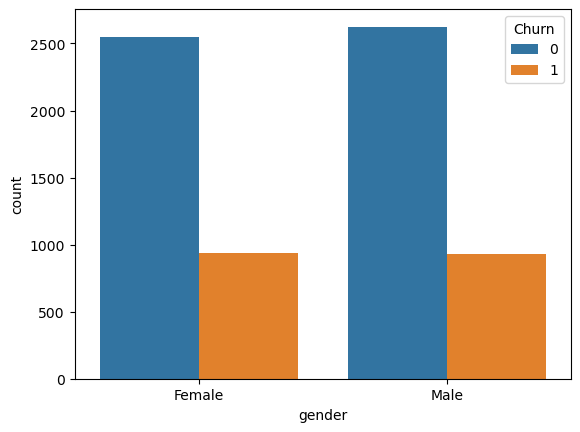

In [18]:
sns.countplot(x=df['gender'],hue=df['Churn'])

In [12]:
# gender label: change female to 1 and male to 0
gender_label=[]
for i, column in df.iterrows():
    if column['gender']=='Male':
        y=0
    else:
        y=1
    gender_label.append(y)

In [19]:
df['gender_label']=gender_label
df[['gender','gender_label']].sample(3)

,gender,gender_label
6337,Female,1
4222,Male,0
5926,Male,0


In [20]:
# multiple lines label
multiplelines_label=[]
for i, column in df.iterrows():
    if column['MultipleLines']=='No phone service':
        y=0
    elif column['MultipleLines']==0:
        y=1
    else:
        y=2
    multiplelines_label.append(y)

In [21]:
df['multiplelines_label']=multiplelines_label
df[['MultipleLines','multiplelines_label']].sample(3)

,MultipleLines,multiplelines_label
781,0,1
3078,1,2
2983,1,2


In [22]:
df['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
0              1526
Name: count, dtype: int64

In [23]:
# Internet Service
internetservice_label=[]
for i, column in df.iterrows():
    if column['InternetService']=='Fiber optic':
        y=2
    elif column['InternetService']=='DSL':
        y=1
    else:
        y=0
    internetservice_label.append(y)

In [24]:
df['internetservice_label']=internetservice_label
df[['InternetService','internetservice_label']].sample(3)

,InternetService,internetservice_label
4087,0,0
2719,DSL,1
3947,DSL,1


In [25]:
# Online Security
df['OnlineSecurity'].value_counts()

OnlineSecurity
0                      3498
1                      2019
No internet service    1526
Name: count, dtype: int64

In [26]:
onlinesecurity_label=[]
for i, column in df.iterrows():
    if column['OnlineSecurity']==1:
        y=2
    elif column['OnlineSecurity']==0:
        y=1
    else:
        y=0
    onlinesecurity_label.append(y)

In [27]:
df['onlinesecurity_label']=onlinesecurity_label
df[['OnlineSecurity','onlinesecurity_label']].sample(3)

,OnlineSecurity,onlinesecurity_label
471,0,1
4606,No internet service,0
1437,0,1


In [28]:
# Online backup
df['OnlineBackup'].value_counts()

OnlineBackup
0                      3088
1                      2429
No internet service    1526
Name: count, dtype: int64

In [29]:
onlinebackup_label=[]
for i, column in df.iterrows():
    if column['OnlineBackup']==1:
        y=2
    elif column['OnlineBackup']==0:
        y=1
    else:
        y=0
    onlinebackup_label.append(y)

In [30]:
df['onlinebackup_label']=onlinebackup_label
df[['OnlineBackup','onlinebackup_label']].sample(3)

,OnlineBackup,onlinebackup_label
1070,0,1
5605,0,1
4128,1,2


In [31]:
# Device protect
df['DeviceProtection'].value_counts()

DeviceProtection
0                      3095
1                      2422
No internet service    1526
Name: count, dtype: int64

In [32]:
deviceprotect_label=[]
for i, column in df.iterrows():
    if column['DeviceProtection']==1:
        y=2
    elif column['DeviceProtection']==0:
        y=1
    else:
        y=0
    deviceprotect_label.append(y)

In [33]:
df['deviceprotect_label']=deviceprotect_label
df[['DeviceProtection','deviceprotect_label']].sample(3)

,DeviceProtection,deviceprotect_label
3161,No internet service,0
3778,0,1
6869,0,1


In [34]:
# Tech support
df['TechSupport'].value_counts()

TechSupport
0                      3473
1                      2044
No internet service    1526
Name: count, dtype: int64

In [35]:
techsupport_label=[]
for i, column in df.iterrows():
    if column['TechSupport']==1:
        y=2
    elif column['TechSupport']==0:
        y=1
    else:
        y=0
    techsupport_label.append(y)

In [36]:
df['techsupport_label']=techsupport_label
df[['TechSupport','techsupport_label']].sample(3)

,TechSupport,techsupport_label
2129,0,1
362,0,1
1698,1,2


In [37]:
# streaming TV
df['StreamingTV'].value_counts()

StreamingTV
0                      2810
1                      2707
No internet service    1526
Name: count, dtype: int64

In [38]:
streamingtv_label=[]
for i, column in df.iterrows():
    if column['StreamingTV']==1:
        y=2
    elif column['StreamingTV']==0:
        y=1
    else:
        y=0
    streamingtv_label.append(y)

In [39]:
df['streamingtv_label']=streamingtv_label
df[['StreamingTV','streamingtv_label']].sample(3)

,StreamingTV,streamingtv_label
2508,1,2
1102,0,1
315,1,2


In [40]:
# streaming movies
df['StreamingMovies'].value_counts()

StreamingMovies
0                      2785
1                      2732
No internet service    1526
Name: count, dtype: int64

In [41]:
streamingmovies_label=[]
for i, column in df.iterrows():
    if column['StreamingMovies']==1:
        y=2
    elif column['StreamingMovies']==0:
        y=1
    else:
        y=0
    streamingmovies_label.append(y)

In [42]:
df['streamingmovies_label']=streamingmovies_label
df[['StreamingMovies','streamingmovies_label']].sample(3)

,StreamingMovies,streamingmovies_label
838,1,2
601,No internet service,0
3288,No internet service,0


In [43]:
# contract
df['Contract'].value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [44]:
contract_label=[]
for i, column in df.iterrows():
    if column['Contract']=='Two year':
        y=2
    elif column['Contract']=='One year':
        y=1
    else:
        y=0
    contract_label.append(y)

In [45]:
df['contract_label']=contract_label
df[['Contract','contract_label']].sample(3)

,Contract,contract_label
157,One year,1
2475,Two year,2
3749,Month-to-month,0


In [46]:
# payment method
df['PaymentMethod'].value_counts()

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [47]:
payment_label=[]
for i, column in df.iterrows():
    if column['PaymentMethod']=='Bank transfer (automatic)':
        y=3
    elif column['PaymentMethod']=='Credit card (automatic)':
        y=2
    elif column['PaymentMethod']=='Electronic check':
        y=1    
    else:
        y=0
    payment_label.append(y)

In [48]:
df['payment_label']=payment_label
df[['PaymentMethod','payment_label']].sample(3)

,PaymentMethod,payment_label
3819,Bank transfer (automatic),3
5027,Electronic check,1
4168,Mailed check,0


In [49]:
# total charges:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df[df['TotalCharges'].isnull()]
# apparently 11 data entries is filled with '', since it is not so significant, I will just drop it

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,multiplelines_label,internetservice_label,onlinesecurity_label,onlinebackup_label,deviceprotect_label,techsupport_label,streamingtv_label,streamingmovies_label,contract_label,payment_label
488,4472-LVYGI,Female,0,1,1,0,0,No phone service,DSL,1,...,0,1,2,1,2,2,2,1,2,3
753,3115-CZMZD,Male,0,0,1,0,1,0,0,No internet service,...,1,0,0,0,0,0,0,0,2,0
936,5709-LVOEQ,Female,0,1,1,0,1,0,DSL,1,...,1,1,2,2,2,1,2,2,2,0
1082,4367-NUYAO,Male,0,1,1,0,1,1,0,No internet service,...,2,0,0,0,0,0,0,0,2,0
1340,1371-DWPAZ,Female,0,1,1,0,0,No phone service,DSL,1,...,0,1,2,2,2,2,2,1,2,2
3331,7644-OMVMY,Male,0,1,1,0,1,0,0,No internet service,...,1,0,0,0,0,0,0,0,2,0
3826,3213-VVOLG,Male,0,1,1,0,1,1,0,No internet service,...,2,0,0,0,0,0,0,0,2,0
4380,2520-SGTTA,Female,0,1,1,0,1,0,0,No internet service,...,1,0,0,0,0,0,0,0,2,0
5218,2923-ARZLG,Male,0,1,1,0,1,0,0,No internet service,...,1,0,0,0,0,0,0,0,1,0
6670,4075-WKNIU,Female,0,1,1,0,1,1,DSL,0,...,2,1,1,2,2,2,2,1,2,0


In [50]:
df1=df[~df['TotalCharges'].isnull()]

In [51]:
#churn
df1['Churn'].value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [52]:
df2=df1[['customerID','gender_label','SeniorCitizen','Partner','Dependents','tenure','PhoneService','multiplelines_label','internetservice_label','onlinesecurity_label','onlinebackup_label','deviceprotect_label','techsupport_label','streamingtv_label','streamingmovies_label','contract_label','PaperlessBilling','payment_label','MonthlyCharges','TotalCharges','Churn']]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customerID             7032 non-null   object 
 1   gender_label           7032 non-null   int64  
 2   SeniorCitizen          7032 non-null   int64  
 3   Partner                7032 non-null   int64  
 4   Dependents             7032 non-null   int64  
 5   tenure                 7032 non-null   int64  
 6   PhoneService           7032 non-null   int64  
 7   multiplelines_label    7032 non-null   int64  
 8   internetservice_label  7032 non-null   int64  
 9   onlinesecurity_label   7032 non-null   int64  
 10  onlinebackup_label     7032 non-null   int64  
 11  deviceprotect_label    7032 non-null   int64  
 12  techsupport_label      7032 non-null   int64  
 13  streamingtv_label      7032 non-null   int64  
 14  streamingmovies_label  7032 non-null   int64  
 15  contract_

### Category Data Summary

- 18 columns were initially identified as objects; 17 of them are necessary columns, while the other one is only the customer ID.
- All of the category columns have been changed to integer values.
- Most of them have almost the same values: yes, no, and no internet service. There is a possibility to merge all of those columns into one.
- The Total Charge column apparently contains '' in its values; therefore, changing it to NaN is necessary. Eventually, the null values were removed considering their insignificance.

### Numeric Data

In [54]:
numeric=['tenure','MonthlyCharges']
df2[numeric].head()

,tenure,MonthlyCharges
0,1,29.85
1,34,56.95
2,2,53.85
3,45,42.30
4,2,70.70


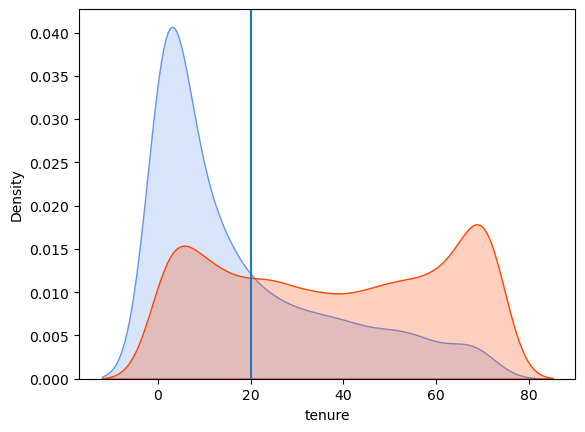

In [55]:
# tenure
yes=df2[df2['Churn']==1]
no=df2[df2['Churn']==0]
sns.kdeplot(yes['tenure'],fill=True,color='cornflowerblue')
sns.kdeplot(no['tenure'],fill=True,color='orangered')
plt.axvline(x=20);
# the tenure can be labeled into two categories here, below and above 20s

In [59]:
tenure_label=[]
for index, column in df2.iterrows():
    if column['tenure']<20:
        y=1
    else:
        y=0
    tenure_label.append(y)

In [64]:
df2=df2.copy()
df2['tenure_label']=tenure_label

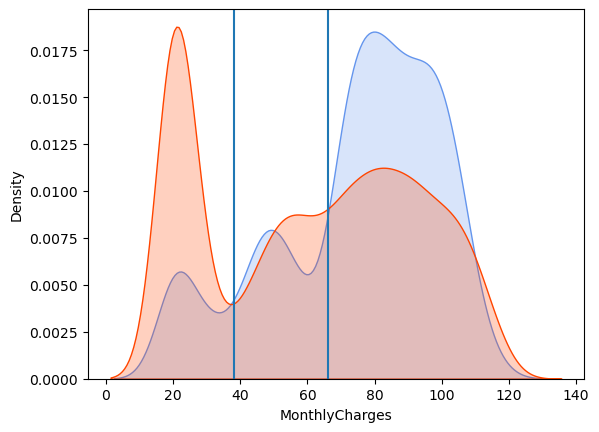

In [61]:
#monthly charges
sns.kdeplot(yes['MonthlyCharges'],fill=True,color='cornflowerblue')
sns.kdeplot(no['MonthlyCharges'],fill=True,color='orangered')
plt.axvline(x=38)
plt.axvline(x=66);
# the monthly charges can be labeled into three categories here, below 38, 38 - 66, above 66 

In [62]:
monthlycharges_label=[]
for index, column in df2.iterrows():
    if column['MonthlyCharges']<38:
        y=0
    elif column['MonthlyCharges']>66:
        y=2
    else:
        y=1
    monthlycharges_label.append(y)

In [65]:
df2=df2.copy()
df2['monthlycharges_label']=monthlycharges_label

In [66]:
# Trial of merging some columns
df2=df2.copy()
df2['summary_label']=df2['multiplelines_label']+df2['onlinesecurity_label']+df2['onlinebackup_label']+df2['deviceprotect_label']+df2['techsupport_label']
df2['streaming']=df2['streamingtv_label']+df2['streamingmovies_label']

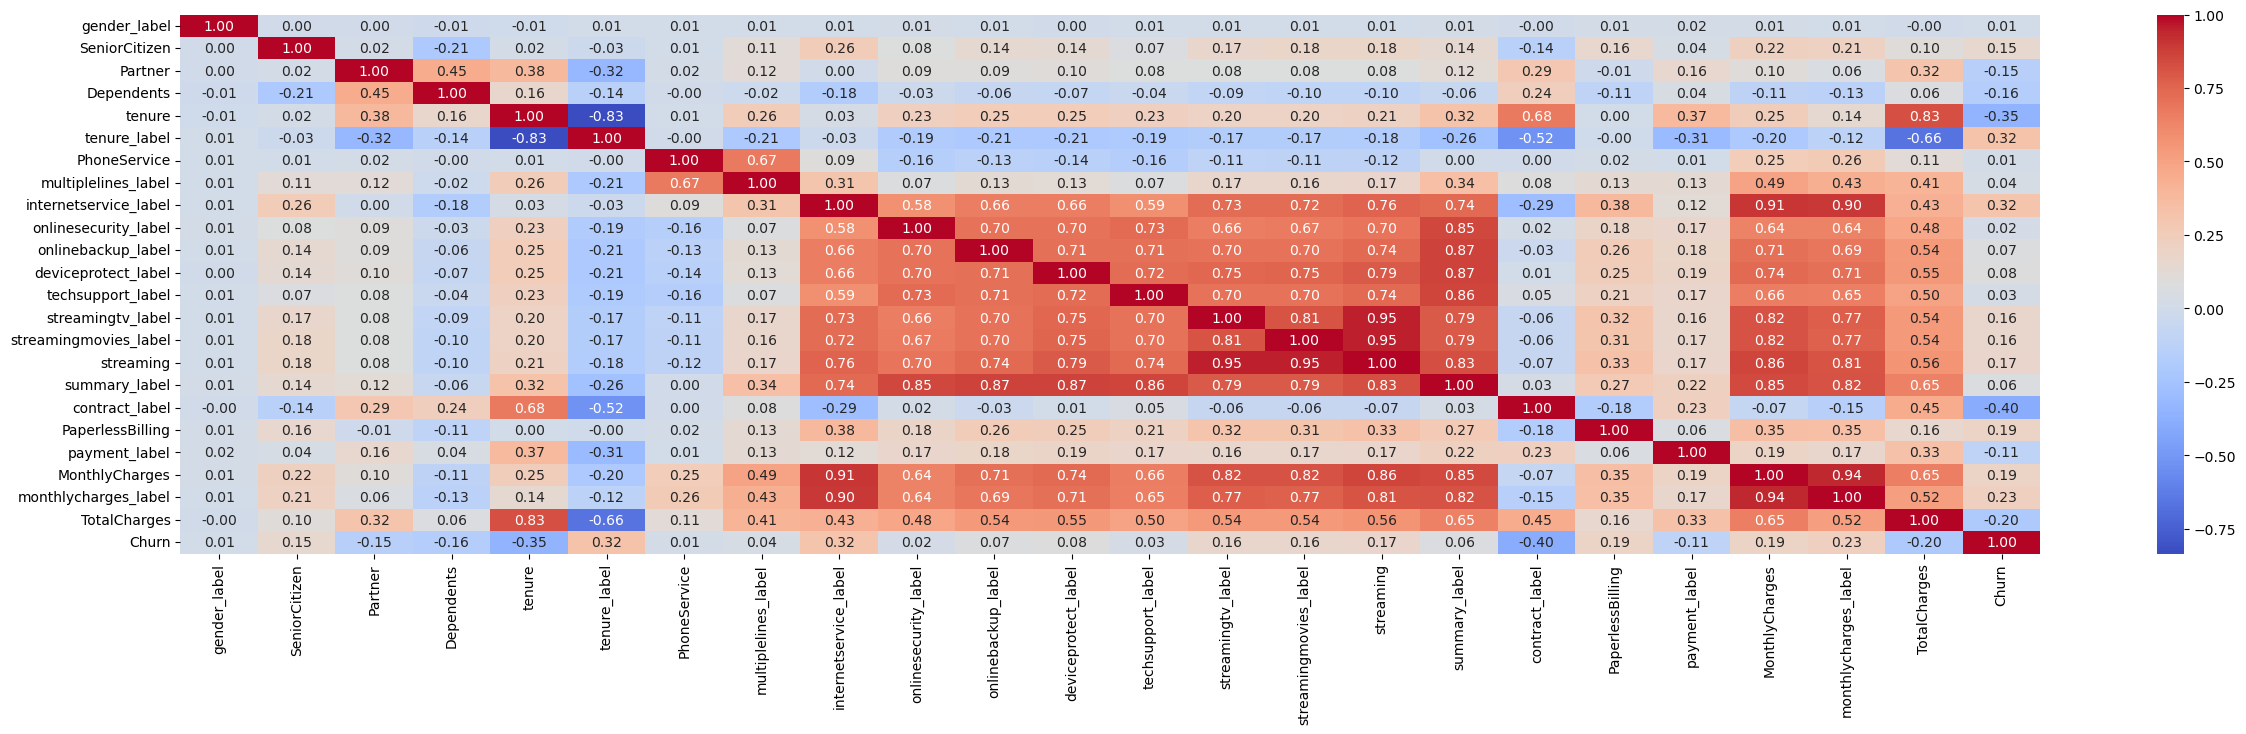

In [68]:
# heatmap
correlation_matrix=df2[['gender_label','SeniorCitizen','Partner','Dependents','tenure','tenure_label','PhoneService','multiplelines_label','internetservice_label','onlinesecurity_label','onlinebackup_label','deviceprotect_label','techsupport_label','streamingtv_label','streamingmovies_label','streaming','summary_label','contract_label','PaperlessBilling','payment_label','MonthlyCharges','monthlycharges_label','TotalCharges','Churn']].corr()
plt.figure(figsize=(30,7))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',fmt='.2f');

<Axes: >

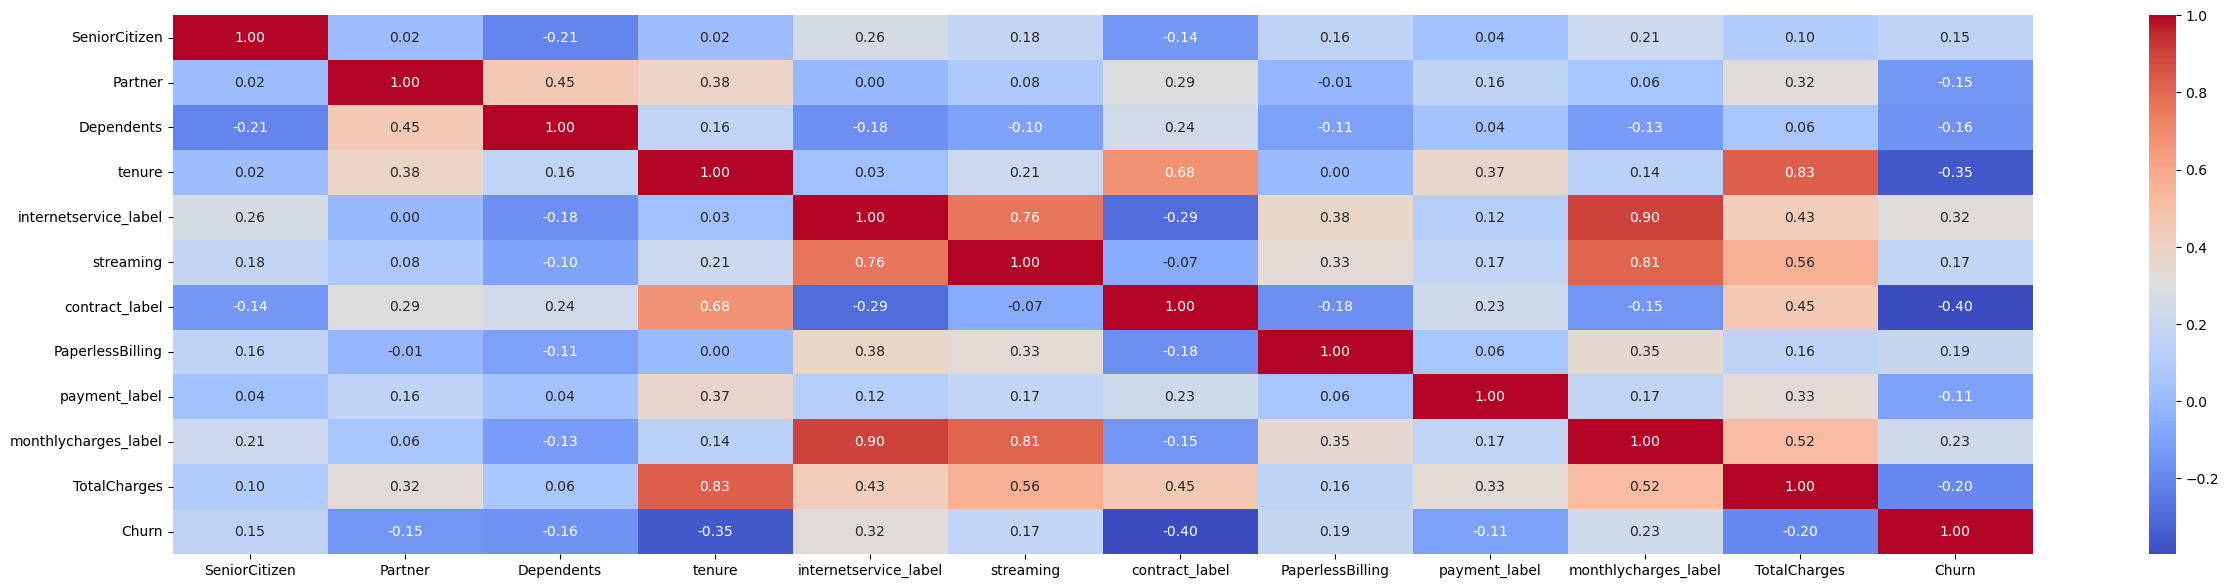

In [69]:
# final correlation heatmap
correlation_matrix=df2[['SeniorCitizen','Partner','Dependents','tenure','internetservice_label','streaming','contract_label','PaperlessBilling','payment_label','monthlycharges_label','TotalCharges','Churn']].corr()
plt.figure(figsize=(30,7))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',fmt='.2f')

In [70]:
df3=df2[['customerID','SeniorCitizen','Partner','Dependents','tenure','internetservice_label','streaming','contract_label','PaperlessBilling','payment_label','monthlycharges_label','TotalCharges','Churn']]

In [71]:
#handling data imbalance in churn
x=df3.drop('Churn',axis=1)
y=df3['Churn']

In [72]:
x_over,y_over=over_sampling.RandomOverSampler().fit_resample(x,y)
df4=x_over
df4['Churn']=y_over
df4['Churn'].value_counts()

Churn
0    5163
1    5163
Name: count, dtype: int64

- The tenure column has a high correlation with churn, higher than the tenure label; hence, it is better to keep it as it is.
- On the other hand, labeling the monthly charges effectively increases the correlation; hence, the latter will be used as the label one.
- Too avoid too much features, column with low correlation were dropped (lower than 0.1) and streaming tv & streaming movies were merged to 'streaming'
- the latest table is consist of 11 column
- The imbalance in churn was handled by doing oversampling

## Modelling Churn Prediction

In [73]:
## Split train and test data
x=df4.drop(columns=['Churn','customerID'],axis=1)
y=df4['Churn']
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=42)

In [74]:
## Scaled the Data
scaler=StandardScaler()
xtrain_scaled=scaler.fit_transform(xtrain)
xtrain_scaled2=scaler.transform(xtrain)
xtest_scaled=scaler.transform(xtest)

In [75]:
# model training
model=[LogisticRegression(max_iter=1000),
      KNeighborsClassifier(n_neighbors=10,weights='distance',algorithm='auto',p=1,leaf_size=30),
      DecisionTreeClassifier(max_depth=5,min_samples_split=10,min_samples_leaf=5),
      RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_split=5,min_samples_leaf=5),
      AdaBoostClassifier(n_estimators=100, learning_rate=0.5, algorithm='SAMME'),
      XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)]

In [76]:
test_dict=[]
for m in model:
    m.fit(xtrain_scaled,ytrain)
    ypred=m.predict(xtest_scaled)
    model_name=str(type(m)).split('.')[-1][:-2]
    accuracy=accuracy_score(ytest,ypred)
    precision=precision_score(ytest,ypred)
    recall=recall_score(ytest,ypred)
    ROC_AUC=roc_auc_score(ytest, m.predict_proba(xtest_scaled)[:,1])
    test_dict.append({
        'model':model_name,
        'accuracy':accuracy,
        'precision':precision,
        'recall':recall,
        'ROC-AUC':ROC_AUC
    })

df_test=pd.DataFrame(test_dict)
df_test

,model,accuracy,precision,recall,ROC-AUC
0,LogisticRegression,0.759199,0.735804,0.801954,0.837847
1,KNeighborsClassifier,0.843447,0.785637,0.940717,0.950411
2,DecisionTreeClassifier,0.758554,0.724472,0.827362,0.838376
3,RandomForestClassifier,0.769852,0.736751,0.833225,0.843962
4,AdaBoostClassifier,0.766946,0.738137,0.820847,0.845183
5,XGBClassifier,0.788573,0.757310,0.843648,0.868943


In [77]:
# checking overfitting
train_dict=[]
for m in model:
    m.fit(xtrain_scaled,ytrain)
    ypred=m.predict(xtrain_scaled2)
    model_name=str(type(m)).split('.')[-1][:-2]
    accuracy=accuracy_score(ytrain,ypred)
    precision=precision_score(ytrain,ypred)
    recall=recall_score(ytrain,ypred)
    ROC_AUC=roc_auc_score(ytrain, m.predict_proba(xtrain_scaled2)[:,1])
    train_dict.append({
        'model':model_name,
        'accuracy':accuracy,
        'precision':precision,
        'recall':recall,
        'ROC-AUC':ROC_AUC
    })

df_train=pd.DataFrame(train_dict)
df_train

,model,accuracy,precision,recall,ROC-AUC
0,LogisticRegression,0.764250,0.741587,0.813947,0.848565
1,KNeighborsClassifier,0.997510,0.996425,0.998622,0.999982
2,DecisionTreeClassifier,0.779054,0.747623,0.845094,0.855037
3,RandomForestClassifier,0.781544,0.752776,0.840959,0.861443
4,AdaBoostClassifier,0.775042,0.748634,0.830761,0.855365
5,XGBClassifier,0.827753,0.796025,0.883131,0.907417


In [78]:
# Checking feature impoprtances
dt=DecisionTreeClassifier(max_depth=5,
                          min_samples_split=10,
                          min_samples_leaf=5
)
dt.fit(xtrain_scaled,ytrain)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10)

<Axes: >

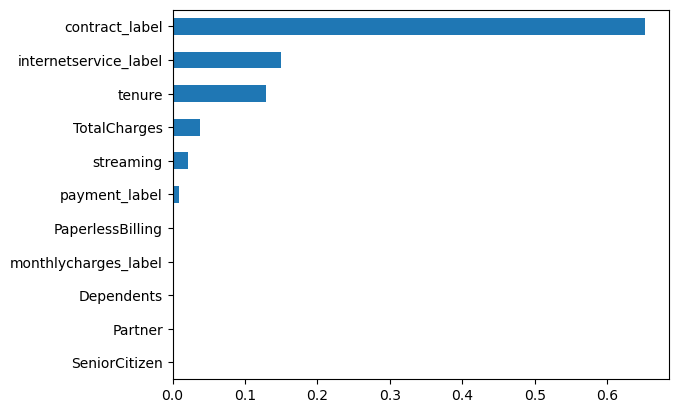

In [79]:
feat_importances=pd.Series(dt.feature_importances_,index=xtrain.columns)
feat_importances.sort_values().plot(kind='barh')

<Axes: xlabel='contract_label', ylabel='count'>

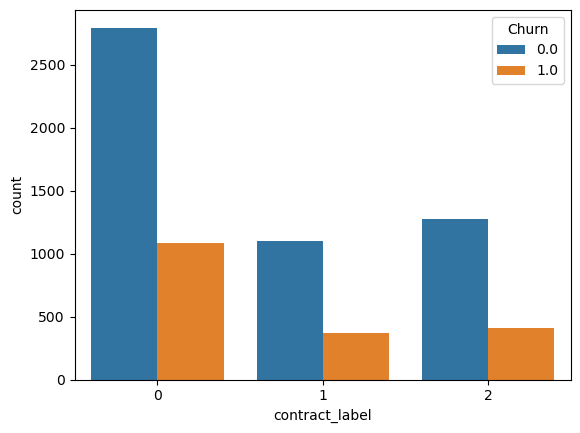

In [80]:
# contract label to churn
sns.countplot(x=df4['contract_label'],hue=df['Churn'])

Customer with month to month contract tend to churn

<Axes: xlabel='internetservice_label', ylabel='count'>

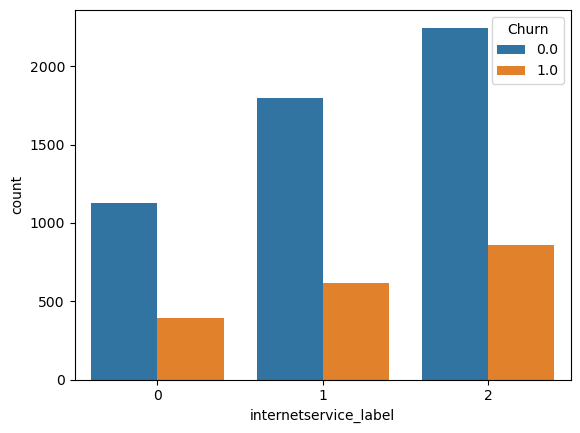

In [218]:
# internet service
sns.countplot(x=df4['internetservice_label'],hue=df['Churn'])

Customer with fiber optic service tend to churn compare to the DSL and no internet service

<Axes: xlabel='tenure', ylabel='Density'>

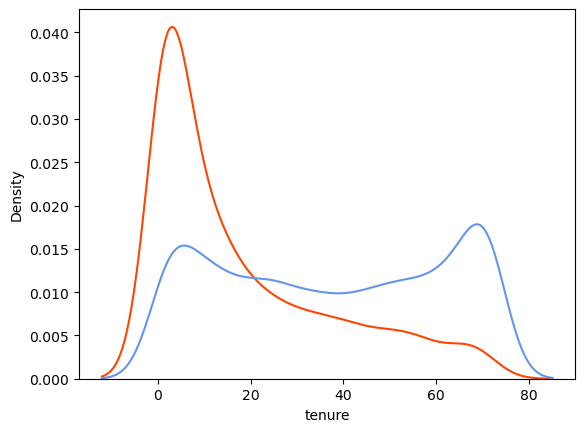

In [219]:
# tenure
sns.kdeplot(yes['tenure'],color='orangered')
sns.kdeplot(no['tenure'],color='cornflowerblue')

customer with tenure under 20 months tend to churn

<Axes: xlabel='TotalCharges', ylabel='Density'>

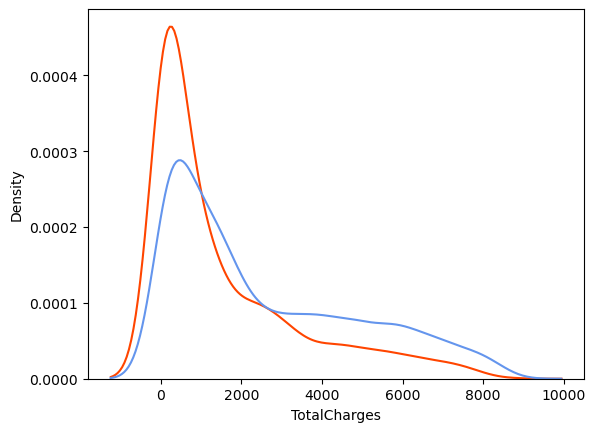

In [83]:
# monthly charges
sns.kdeplot(yes['TotalCharges'],color='orangered')
sns.kdeplot(no['TotalCharges'],color='cornflowerblue')

## Modelling Churn Prediction Summary

- Recall is the priority to ensure the majority of the potential churn is captured.
- 6 models are evaluated, Logistic Regression, knn, decision tree, random forest, adaboost, and xgboost.
- Considering the interpretability, avoiding overfitting, and high recall, decision tree model was chosen.
- Based on the barplot, contract label is the most important feature, followed by internet service, tenure, and total charges

## Churn Customer Clustering

contract label, internet service, and tenure will be used for the clustering dimension considering its high importance

In [84]:
cluster=['contract_label','internetservice_label','tenure']

In [85]:
# Data preparation
df_c=df4[df4['Churn']==1][cluster]
df_c

,contract_label,internetservice_label,tenure
2,0,1,2
4,0,2,2
5,0,2,8
8,0,2,28
13,0,2,49
...,...,...,...
10321,0,2,7
10322,0,2,3
10323,0,2,13
10324,0,1,3


In [86]:
# Data scaled
c_scaled=StandardScaler().fit_transform(df_c)
df_c_scaled=pd.DataFrame(data=c_scaled,columns=cluster)
df_c_scaled

,contract_label,internetservice_label,tenure
0,-0.327451,-1.069563,-0.803156
1,-0.327451,0.621237,-0.803156
2,-0.327451,0.621237,-0.491777
3,-0.327451,0.621237,0.546156
4,-0.327451,0.621237,1.635985
...,...,...,...
5158,-0.327451,0.621237,-0.543673
5159,-0.327451,0.621237,-0.751260
5160,-0.327451,0.621237,-0.232293
5161,-0.327451,-1.069563,-0.751260


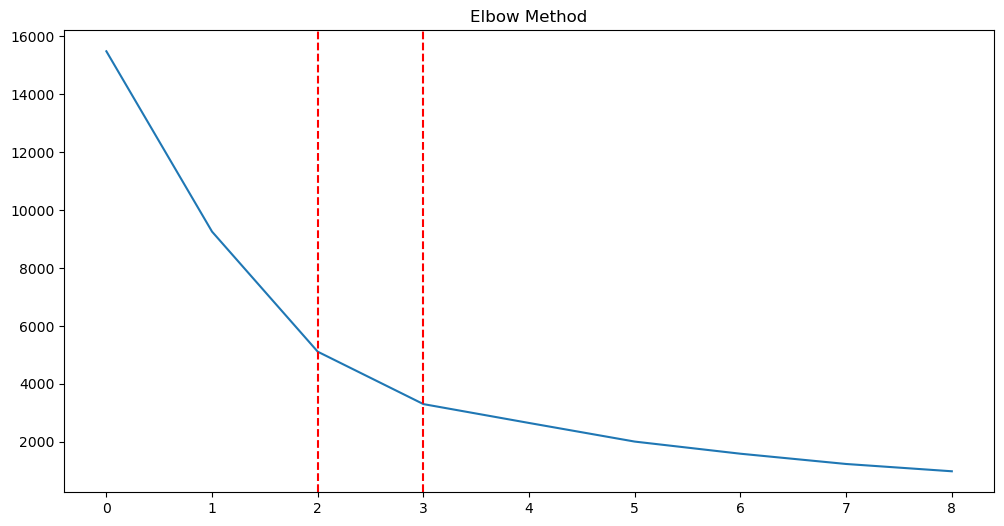

In [87]:
# Identify the best n cluster
inertia=[]
for i in range (1,10):
    kmeans1=KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans1.fit(df_c_scaled.values)
    inertia.append(kmeans1.inertia_)

plt.figure(figsize=(12,6))
plt.plot(inertia)
plt.title('Elbow Method')
plt.axvline(2,linestyle='--',color='red')
plt.axvline(3,linestyle='--',color='red');

The best cluster is between 2 or 3, the decision will be made after checking the logic between both clusters

In [88]:
kmeans2=KMeans(n_clusters=2,init='k-means++',max_iter=300,n_init=10,random_state=42)
kmeans2.fit(df_c_scaled.values)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [89]:
kmeans3=KMeans(n_clusters=3,init='k-means++',max_iter=300,n_init=10,random_state=42)
kmeans3.fit(df_c_scaled.values)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [90]:
df_c_final=df_c.copy()
df_c_final['cluster2']=kmeans2.labels_
df_c_final['cluster3']=kmeans3.labels_

In [95]:
df_c_final.groupby('cluster2')[['contract_label','internetservice_label','tenure']].agg(['mean','median','count'])

contract_label              internetservice_label               \
                   mean median count                  mean median count   
cluster2                                                                  
0              0.000000    0.0  4605              1.641260    2.0  4605   
1              1.224014    1.0   558              1.560932    2.0   558   

             tenure               
               mean median count  
cluster2                          
0         13.681433    7.0  4605  
1         48.792115   53.0   558

#### Interpretation
- Cluster 0 (early churner)
    - Characteristics: Short tenure, month-to-month contracts, fiber optic internet
    - Primary Churn Drivers: Lack of commitment, unmet expectations, poor onboarding
    - Recommendation: Focus on onboarding, incentives for long-term contracts, and quick issue resolution
- Cluster 1 (loyal but lost)
    - Characteristics: Long tenure, one-year contracts, fiber optic internet
    - Primary Churn Drivers: Competitor offers, pricing dissatisfaction, lack of loyalty programs
    - Recommendation: Introduce loyalty rewards, personalized engagement, and competitive pricing

In [94]:
df_c_final.groupby('cluster3')[['contract_label','internetservice_label','tenure']].agg(['mean','median','count'])

contract_label              internetservice_label               \
                   mean median count                  mean median count   
cluster3                                                                  
0              0.018453    0.0  1409              0.798439    1.0  1409   
1              0.000930    0.0  3225              2.000000    2.0  3225   
2              1.236295    1.0   529              1.614367    2.0   529   

            tenure               
              mean median count  
cluster3                         
0          8.53939    3.0  1409  
1         15.88186   10.0  3225  
2         50.99811   54.0   529

#### Interpretation
- Cluster 0 (early churner)
    - Characteristics: Month-to-month contracts, DSL internet, short tenure
    - Primary Churn Drivers: Low commitment, poor service quality, onboarding issues
    - Recommendation: Improve onboarding, address DSL issues, offer contract incentives
- Cluster 1 (loyal but lost)
    - Characteristics: Month-to-month contracts, fiber optic internet, moderate tenure
    - Primary Churn Drivers: Pricing dissatisfaction, competitor offers, service reliability
    - Recommendation: Competitive pricing, service reliability focus, retention offers
- Cluster 2 (loyal but lost)
    - Characteristics: One-year contracts, fiber optic & DSL internet, long tenure
    - Primary Churn Drivers: Competitor attraction, pricing dissatisfaction, lack of loyalty rewards
    - Recommendation: Loyalty programs, personalized pricing, exit interviews

## Churn Customer Clustering

- 3 features are chosen considering its importance, contract, internet service, and tenure
- Based on elbow method, the best cluster is between 2 and 3
- After making the clusters, the best cluster is 3 since it gives a deeper insight on the customer behaviour.